In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df_seq = pd.read_csv('/root/DeepTTA/smiles(Secondary_Screen_treatment_info)_union.txt', header=0)

In [5]:
df_seq

,smiles
0,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...
1,C[C@]12CCC3C(CCC4=C3CCC(=O)C4)C1CC[C@@]2(O)C#C
2,CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=...
3,C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...
4,CN1CCCCC1C(=O)Nc1c(C)cccc1C
...,...
1437,CC1(C)Oc2ccc(cc2[C@H]([C@@H]1O)N1CCCC1=O)C#N.C...
1438,CCO.CC1=C(C(c2cccc(c2)[N+]([O-])=O)C(=C(C)N1)P...
1439,[Na].OC(=O)C(Cl)Cl
1440,C=O.C1CO1.CC(C)(C)CC(C)(C)c1ccc(O)cc1


In [6]:
# df_seq[0].values[0]
df_seq["smiles"].values[1]

'C[C@]12CCC3C(CCC4=C3CCC(=O)C4)C1CC[C@@]2(O)C#C'

In [7]:
import os
import sys
import inspect
import codecs
import re
import copy
import argparse
import warnings
from collections import defaultdict, Counter

def get_vocabulary(seqs, is_dict=False):
    """Read text and return dictionary that encodes vocabulary
    vocab = Counter()
    for i, line in enumerate(fobj):
        if is_dict:
            try:
                word, count = line.strip('\r\n ').split(' ')
            except:
                print('Failed reading vocabulary file at line {0}: {1}'.format(i, line))
                sys.exit(1)
            vocab[word] += int(count)
        else:
            for word in line.strip('\r\n ').split(' '):
                if word:
                    vocab[word] += 1
        """
    
    vocab = Counter()
    for seq in seqs:
        vocab[seq] += 1
    return vocab

def update_pair_statistics(pair, changed, stats, indices):
    """Minimally update the indices and frequency of symbol pairs
    if we merge a pair of symbols, only pairs that overlap with occurrences
    of this pair are affected, and need to be updated.
    """
    stats[pair] = 0
    indices[pair] = defaultdict(int)
    first, second = pair
    new_pair = first+second
    for j, word, old_word, freq in changed:

        # find all instances of pair, and update frequency/indices around it
        i = 0
        while True:
            # find first symbol
            try:
                i = old_word.index(first, i)
            except ValueError:
                break
            # if first symbol is followed by second symbol, we've found an occurrence of pair (old_word[i:i+2])
            if i < len(old_word)-1 and old_word[i+1] == second:
                # assuming a symbol sequence "A B C", if "B C" is merged, reduce the frequency of "A B"
                if i:
                    prev = old_word[i-1:i+1]
                    stats[prev] -= freq
                    indices[prev][j] -= 1
                if i < len(old_word)-2:
                    # assuming a symbol sequence "A B C B", if "B C" is merged, reduce the frequency of "C B".
                    # however, skip this if the sequence is A B C B C, because the frequency of "C B" will be reduced by the previous code block
                    if old_word[i+2] != first or i >= len(old_word)-3 or old_word[i+3] != second:
                        nex = old_word[i+1:i+3]
                        stats[nex] -= freq
                        indices[nex][j] -= 1
                i += 2
            else:
                i += 1

        i = 0
        while True:
            try:
                # find new pair
                i = word.index(new_pair, i)
            except ValueError:
                break
            # assuming a symbol sequence "A BC D", if "B C" is merged, increase the frequency of "A BC"
            if i:
                prev = word[i-1:i+1]
                stats[prev] += freq
                indices[prev][j] += 1
            # assuming a symbol sequence "A BC B", if "B C" is merged, increase the frequency of "BC B"
            # however, if the sequence is A BC BC, skip this step because the count of "BC BC" will be incremented by the previous code block
            if i < len(word)-1 and word[i+1] != new_pair:
                nex = word[i:i+2]
                stats[nex] += freq
                indices[nex][j] += 1
            i += 1


def get_pair_statistics(vocab): # input: sorted_vocab
    """Count frequency of all symbol pairs, and create index"""

    # data structure of pair frequencies
    stats = defaultdict(int) # stats : defaultdict(<class 'int'>, {})
    
    #index from pairs to words
    indices = defaultdict(lambda: defaultdict(int))
    for i, (word, freq) in enumerate(vocab):
        prev_char = word[0]
        for char in word[1:]:
            stats[prev_char, char] += freq
            indices[prev_char, char][i] += 1
            prev_char = char

    return stats, indices


def replace_pair(pair, vocab, indices):
    """Replace all occurrences of a symbol pair ('A', 'B') with a new symbol 'AB'"""
    first, second = pair
    pair_str = ''.join(pair)
    pair_str = pair_str.replace('\\','\\\\')
    changes = []
    pattern = re.compile(r'(?<!\S)' + re.escape(first + ' ' + second) + r'(?!\S)')
    if sys.version_info < (3, 0):
        iterator = indices[pair].iteritems()
    else:
        iterator = indices[pair].items()
    for j, freq in iterator:
        if freq < 1:
            continue
        word, freq = vocab[j]
        new_word = ' '.join(word)
        new_word = pattern.sub(pair_str, new_word)
        new_word = tuple(new_word.split(' '))

        vocab[j] = (new_word, freq)
        changes.append((j, new_word, word, freq))

    return changes

def prune_stats(stats, big_stats, threshold):
    """Prune statistics dict for efficiency of max()
    The frequency of a symbol pair never increases, so pruning is generally safe
    (until we the most frequent pair is less frequent than a pair we previously pruned)
    big_stats keeps full statistics for when we need to access pruned items
    """
    for item,freq in list(stats.items()):
        if freq < threshold:
            del stats[item]
            if freq < 0:
                big_stats[item] += freq
            else:
                big_stats[item] = freq


def learn_bpe(infile, outfile, num_symbols, min_frequency=2, verbose=False, is_dict=False, total_symbols=False):
    """Learn num_symbols BPE operations from vocabulary, and write to outfile.
    """
    # learn_bpe(seq, output, 30000, min_frequency=1500, verbose=True, is_dict=False, total_symbols=True)

    # version 0.2 changes the handling of the end-of-word token ('</w>');
    # version numbering allows bckward compatibility
    outfile.write('#version: 0.2\n')

    vocab = get_vocabulary(infile, is_dict) # 每個藥SMILES出現幾次的dict
    vocab = dict([(tuple(x[:-1])+(x[-1]+'</w>',) ,y) for (x,y) in vocab.items()])# 把藥的atom全部切開，並在最後一個atom後加上</w>
    
    sorted_vocab = sorted(vocab.items(), key=lambda x: x[1], reverse=True)#按每個藥SMILES出現幾次做排序
    
    stats, indices = get_pair_statistics(sorted_vocab)
    print(stats, indices)
    big_stats = copy.deepcopy(stats)

    if total_symbols:
        uniq_char_internal = set()
        uniq_char_final = set()
        for word in vocab:
            for char in word[:-1]:
                uniq_char_internal.add(char)
            uniq_char_final.add(word[-1])
        sys.stderr.write('Number of word-internal characters: {0}\n'.format(len(uniq_char_internal)))
        sys.stderr.write('Number of word-final characters: {0}\n'.format(len(uniq_char_final)))
        sys.stderr.write('Reducing number of merge operations by {0}\n'.format(len(uniq_char_internal) + len(uniq_char_final)))
        num_symbols -= len(uniq_char_internal) + len(uniq_char_final)
        for i in uniq_char_internal:
            vocab_index2units2freq[i] = 0

    # threshold is inspired by Zipfian assumption, but should only affect speed
    threshold = max(stats.values()) / 10
    for i in range(num_symbols):
        if stats:
            most_frequent = max(stats, key=lambda x: (stats[x], x))

        # we probably missed the best pair because of pruning; go back to full statistics
        if not stats or (i and stats[most_frequent] < threshold):
            prune_stats(stats, big_stats, threshold)
            stats = copy.deepcopy(big_stats)
            most_frequent = max(stats, key=lambda x: (stats[x], x))
            # threshold is inspired by Zipfian assumption, but should only affect speed
            threshold = stats[most_frequent] * i/(i+10000.0)
            prune_stats(stats, big_stats, threshold)

        if stats[most_frequent] < min_frequency:
            sys.stderr.write('no pair has frequency >= {0}. Stopping\n'.format(min_frequency))
            break
        
        #essential
        s1 = most_frequent[0].replace('</w>','')
        s2 = most_frequent[1].replace('</w>','')
        
        vocab_index2units2freq[s1+s2] = stats[most_frequent]
        
        if verbose:
            sys.stderr.write('pair {0}: {1} {2} -> {1}{2} (frequency {3})\n'.format(i, most_frequent[0], most_frequent[1], stats[most_frequent]))
        outfile.write('{0} {1}\n'.format(*most_frequent))
        freq_codes.append(most_frequent)
        changes = replace_pair(most_frequent, sorted_vocab, indices)
        update_pair_statistics(most_frequent, changes, stats, indices)
        stats[most_frequent] = 0
        if not i % 100:
            prune_stats(stats, big_stats, threshold)

In [12]:
freq_codes = []
vocab_index2units2freq = {}
seq = (df_seq["smiles"].values) # seq 為訓練的所有化學SMILES結構
output = open('./drug_codes_chembl_freq_1500_testtest.txt', 'w+')
learn_bpe(seq, output, 30000, min_frequency=1500, verbose=True, is_dict=False, total_symbols=True)

defaultdict(<class 'int'>, {('N', '\\'): 30, ('\\', 'C'): 249, ('C', '('): 2315, ('(', 'S'): 27, ('S', 'c'): 33, ('c', '1'): 2684, ('1', 'c'): 1518, ('c', 'c'): 6290, ('1', 'N'): 91, ('N', ')'): 285, (')', '='): 395, ('=', 'C'): 518, ('(', 'C'): 2490, ('C', '#'): 77, ('#', 'N'): 43, (')', '/'): 2, ('/', 'C'): 65, ('(', '/'): 25, ('/', 'N'): 10, (')', 'S'): 75, ('1', 'N</w>'): 10, ('C', 'O'): 625, ('O', 'c'): 378, ('c', '2'): 1623, ('2', 'n'): 235, ('n', 'c'): 928, ('c', 'n'): 487, ('c', '('): 2335, ('(', 'N'): 601, ('N', 'c'): 427, ('c', '3'): 669, ('3', 'c'): 374, ('C', 'l'): 297, ('l', ')'): 267, (')', 'c'): 2051, ('3', 'F'): 13, ('F', ')'): 475, ('2', 'c'): 897, ('1', 'O'): 189, ('O', 'C'): 720, ('C', '1'): 520, ('1', 'C'): 680, ('C', 'C'): 3411, ('C', 'N'): 642, ('N', '('): 398, ('1', ')'): 710, (')', 'C'): 1694, ('(', '='): 1625, ('=', 'O'): 1835, ('O', ')'): 2815, ('C', '='): 298, ('=', 'C</w>'): 19, ('(', 'c'): 585, ('1', 'n'): 239, ('2', 'P'): 3, ('P', '('): 29, ('C', ')'): 170

Number of word-internal characters: 42
Number of word-final characters: 14
Reducing number of merge operations by 56
pair 0: c c -> cc (frequency 6290)
pair 1: C C -> CC (frequency 3411)
pair 2: O ) -> O) (frequency 2815)
pair 3: c 1 -> c1 (frequency 2302)
pair 4: [ C -> [C (frequency 2280)
pair 5: [C @ -> [C@ (frequency 2279)
pair 6: H ] -> H] (frequency 2047)
pair 7: ( C -> (C (frequency 2033)
pair 8: = O) -> =O) (frequency 1834)
pair 9: ( =O) -> (=O) (frequency 1554)
no pair has frequency >= 1500. Stopping


In [13]:
import codecs 
from subword_nmt.apply_bpe import BPE


bpe_codes_fin = codecs.open('./drug_codes_chembl_freq_1500_testtest.txt')
bpe = BPE(bpe_codes_fin, merges=-1, separator='')


In [14]:
df_seq["smiles"].values[100]

'OC1N=C(c2ccccc2)c2cc(Cl)ccc2NC1=O'

In [16]:
idx2word = list(vocab_index2units2freq.keys())
print(idx2word)

['/', '7', 'S', 'C', 's', 'A', '(', '=', 'I', '-', ']', '5', '#', 'F', ')', '+', 'N', 'Z', 'b', 'c', 'V', '@', 'B', 'o', '\\', '4', 't', '3', 'H', 'e', 'a', '1', 'l', '2', '.', 'n', '[', 'P', 'O', '6', 'r', 'g', 'cc', 'CC', 'O)', 'c1', '[C', '[C@', 'H]', '(C', '=O)', '(=O)']


In [17]:
words2idx = dict(zip(vocab_index2units2freq.keys(), range(0, len(idx2word))))
print(words2idx)

{'/': 0, '7': 1, 'S': 2, 'C': 3, 's': 4, 'A': 5, '(': 6, '=': 7, 'I': 8, '-': 9, ']': 10, '5': 11, '#': 12, 'F': 13, ')': 14, '+': 15, 'N': 16, 'Z': 17, 'b': 18, 'c': 19, 'V': 20, '@': 21, 'B': 22, 'o': 23, '\\': 24, '4': 25, 't': 26, '3': 27, 'H': 28, 'e': 29, 'a': 30, '1': 31, 'l': 32, '2': 33, '.': 34, 'n': 35, '[': 36, 'P': 37, 'O': 38, '6': 39, 'r': 40, 'g': 41, 'cc': 42, 'CC': 43, 'O)': 44, 'c1': 45, '[C': 46, '[C@': 47, 'H]': 48, '(C': 49, '=O)': 50, '(=O)': 51}


In [18]:
tokens=bpe.process_line(df_seq["smiles"].values[100]).split()
print(tokens)
try:
    i1 = np.asarray([words2idx[subword] for subword  in tokens]) # i1: subword在sub_csv file中的index ; i: tokens中的subword
except:# 如果tokens是空值，或tokens中有subword沒有在words2idx_d字典裡
    i1 = np.array([0])
l = len(i1)
print(i1)
print(l)

['O', 'C', '1', 'N', '=', 'C', '(', 'c', '2', 'cc', 'cc', 'c', '2', ')', 'c', '2', 'cc', '(C', 'l', ')', 'cc', 'c', '2', 'N', 'C', '1', '=', 'O']
[38  3 31 16  7  3  6 19 33 42 42 19 33 14 19 33 42 49 32 14 42 19 33 16
  3 31  7 38]
28


In [19]:
word_length_count = defaultdict(int)
for i in range(len(list(vocab_index2units2freq.keys()))):
    word_length_count[len(list(vocab_index2units2freq.keys())[i])] += 1

<BarContainer object of 4 artists>

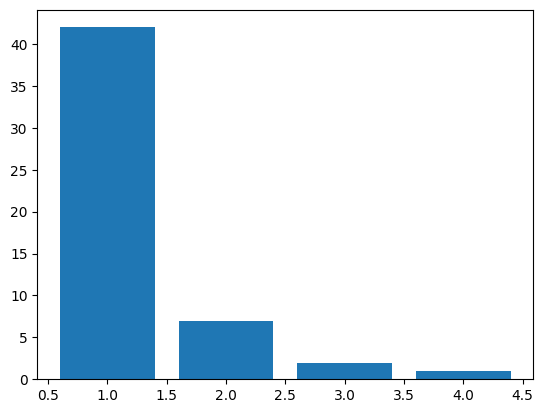

In [20]:
plt.bar(list(word_length_count.keys()), list(word_length_count.values()))

In [21]:
word_length_count

defaultdict(int, {1: 42, 2: 7, 3: 2, 4: 1})

In [22]:
sub_csv = pd.DataFrame(list(vocab_index2units2freq.items()),
                      columns=['index','frequency'])
sub_csv.reset_index(level=0, inplace=True)
sub_csv.to_csv('./subword_units_map_chembl_freq_1500_testtest.csv')

In [23]:
(sub_csv['index'].values)

array(['/', '7', 'S', 'C', 's', 'A', '(', '=', 'I', '-', ']', '5', '#',
       'F', ')', '+', 'N', 'Z', 'b', 'c', 'V', '@', 'B', 'o', '\\', '4',
       't', '3', 'H', 'e', 'a', '1', 'l', '2', '.', 'n', '[', 'P', 'O',
       '6', 'r', 'g', 'cc', 'CC', 'O)', 'c1', '[C', '[C@', 'H]', '(C',
       '=O)', '(=O)'], dtype=object)